In [2]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import json

from pricing.pricing.models.sig_vol import SigVol
from pricing.pricing.models.model_params import LewisParams
from pricing.pricing.products.vanilla_option import VanillaOption
from signature.shuffle import shuffle_product
from signature.characteristic_function import psi_riccati_euler, xi_riccati, psi_riccati_rk4, func_psi
from signature.characteristic_function import psi_riccati_euler_stat, psi_riccati_pece_stat, func_psi_stat
from signature.tensor_algebra import TensorAlgebra
from signature.tensor_sequence import TensorSequence

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 6, 6)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from scipy.optimize import minimize

In [6]:
bounds = [(-100, 100)] * 5
params_minmizer = dict(bounds=bounds, verbose=True, minimizer="differential_evolution", updating="immediate", earlystop_val=1e-6)

In [8]:
minimize(func=lambda x: x**2, **params_minmizer)

TypeError: minimize() got an unexpected keyword argument 'func'

In [2]:
%%time
ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: user 2min 53s, sys: 269 ms, total: 2min 54s
Wall time: 2min 54s


In [3]:
N = 5
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

### Model setup

In [4]:
rho = -0.5

model = SigVol( 
               vol_ts=0.2 * Ø + 0.01 * _1 + 0.1 * _2 + 0.05 * _11 + 0.05 * _12 + 0.05 * _22 + 0.01 * _222 + 0.03 * _221 + 0.01 * _121 + 0.01 * _211, 
               ta=ta, 
               rho=rho)

In [5]:
ta.print(model.vol_ts)

0.2*∅ + 0.01*1 + 0.1*2 + 0.05*11 + 0.05*12 + 0.05*22 + 0.01*121 + 0.01*211 + 0.03*221 + 0.01*222


Text(0.5, 1.0, 'Vol trajectories')

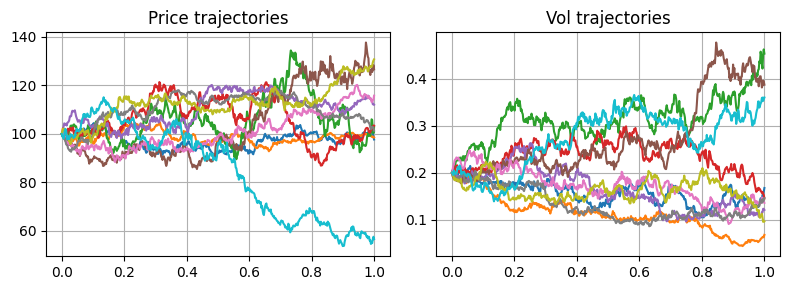

In [6]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")

### Define the option 

In [7]:
T = 1
F0 = 100
K = np.array([90, 100, 110])

k = np.log(K / F0)

option = VanillaOption(T=T, K=K, flag="call")

### Pricing

In [8]:
%%time
smile_cf = option.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                            pricing_params=LewisParams(cf_timestep=0.01))

CPU times: user 1min 40s, sys: 167 ms, total: 1min 40s
Wall time: 1min 25s


In [9]:
%%timeit
smile_cf = option.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                            pricing_params=LewisParams(cf_timestep=0.01))

2.83 s ± 82.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[0.24302767 0.22861162 0.21789193]


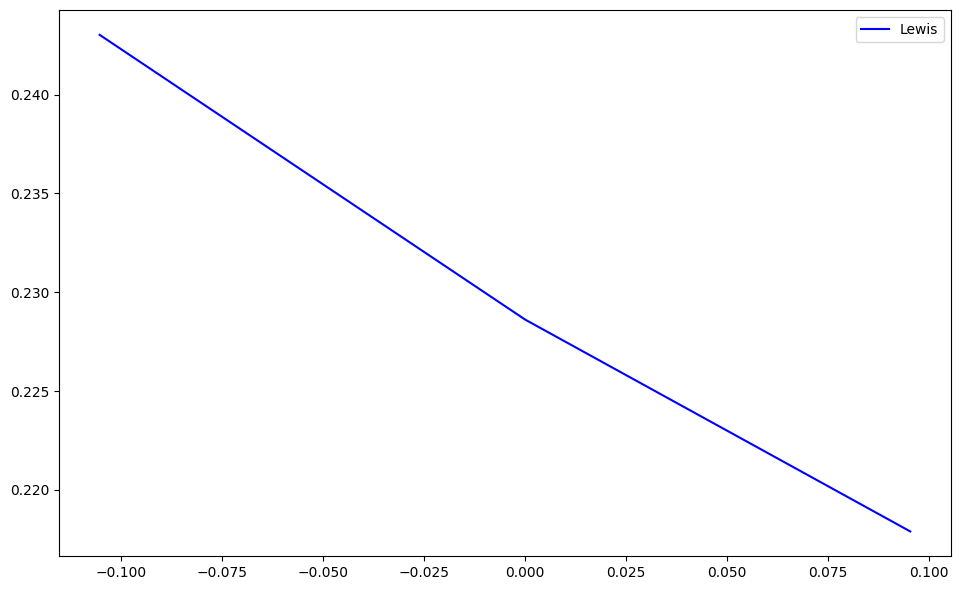

In [10]:
print(smile_cf)

fig, ax = plt.subplots()

ax.plot(np.log(K / F0), smile_cf, "b", label="Lewis")
ax.grid()
ax.legend()

## Signature characteristic function

In [11]:
T = 2
n = 50
trunc = 12
u_coef = -1

t_grid = np.linspace(0, T, n)
u = ta.from_word("2222", trunc=trunc) * u_coef

In [12]:
from signatures.characteristic_function import func_psi

ModuleNotFoundError: No module named 'signatures'

In [ ]:
rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])
path = np.vstack([t_grid, W]).T

W_sig = ta.path_to_sequence(path=path, trunc=10)

#### Via MC

In [ ]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
W_T = rng.normal(size=n_sample) * np.sqrt(T)
sample = np.exp(u_coef * W_T**4 / 24)
sample.mean(), sample.std() / np.sqrt(n_sample)

#### Via quadratures

In [ ]:
from scipy.special import roots_laguerre


N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f(x):
    return np.exp(u_coef * t_grid[:, None]**2 * x[None, :]**4 / 24 - 0.5 * x[None, :]**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad[-1]

In [250]:
from signatures.characteristic_function import *

In [251]:
psi_euler, psi_0_euler = psi_riccati(t_grid=t_grid, u=u)

In [252]:
psi_pece, psi_0_pece = psi_riccati_pece(t_grid=t_grid, u=u)

In [255]:
psi_pecece, psi_0_pecece = psi_riccati_pecece(t_grid=t_grid, u=u)

In [253]:
psi_multi, psi_0_multi = psi_riccati_multistep(t_grid=t_grid, u=u)

In [254]:
psi_rk, psi_0_rk = psi_riccati_rk4(t_grid=t_grid, u=u)

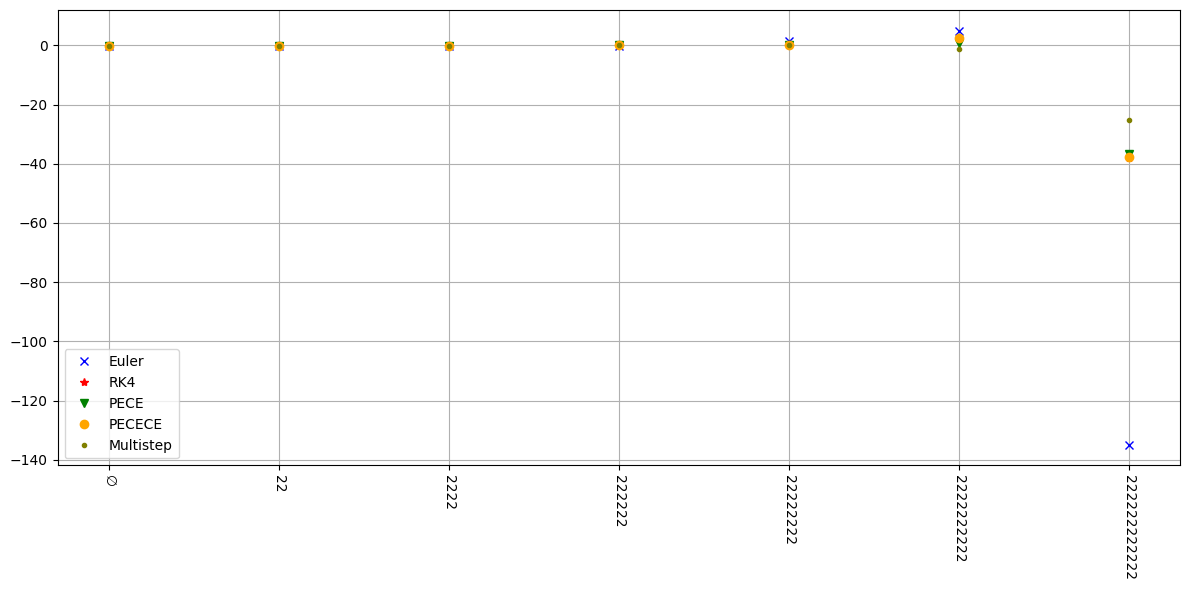

In [258]:
fig, ax = plt.subplots(figsize=(12, 6))

ta.plot_coefficients(ts=psi_euler, nonzero=True, ax=ax, color="b", marker="x", label="Euler")
ta.plot_coefficients(ts=psi_rk, nonzero=True, ax=ax, color="r", marker="*", label="RK4")
ta.plot_coefficients(ts=psi_pece, nonzero=True, ax=ax, color="g", marker="v", label="PECE")
ta.plot_coefficients(ts=psi_pecece, nonzero=True, ax=ax, color="orange", marker="o", label="PECECE")
ta.plot_coefficients(ts=psi_multi, nonzero=True, ax=ax, color="olive", marker=".", label="Multistep")

ax.legend()
# ax.set_ylim([-0.75, 0.05])

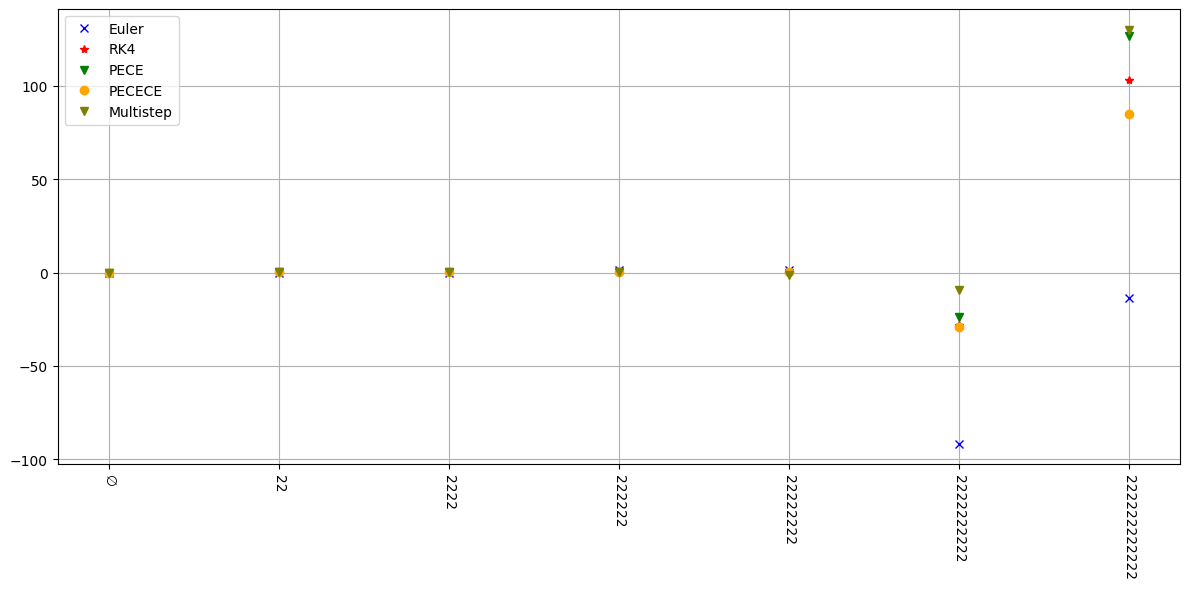

In [260]:
fig, ax = plt.subplots(figsize=(12, 6))

ta.plot_coefficients(ts=func_psi(psi_euler), nonzero=True, ax=ax, color="b", marker="x", label="Euler")
ta.plot_coefficients(ts=func_psi(psi_rk), nonzero=True, ax=ax, color="r", marker="*", label="RK4")
ta.plot_coefficients(ts=func_psi(psi_pece), nonzero=True, ax=ax, color="g", marker="v", label="PECE")
ta.plot_coefficients(ts=func_psi(psi_pecece), nonzero=True, ax=ax, color="orange", marker="o", label="PECECE")
ta.plot_coefficients(ts=func_psi(psi_multi), nonzero=True, ax=ax, color="olive", marker="v", label="Multistep")

# ax.set_ylim([-0.1, 0.05])
ax.legend()

### Dependence on the truncation order

In [261]:
from signatures.shuffle import shuffle_product

/tmp/ipykernel_22049/2089616566.py:16: RuntimeWarning: overflow encountered in exp
  ax.plot(t_grid, np.exp(psi_0_euler), "-", label=f"Euler, N={trunc}")
/tmp/ipykernel_22049/2089616566.py:17: RuntimeWarning: overflow encountered in exp
  ax.plot(t_grid, np.exp(psi_0_pecece), "-", label=f"PECECE, N={trunc}")
/tmp/ipykernel_22049/2089616566.py:18: RuntimeWarning: overflow encountered in exp
  ax.plot(t_grid, np.exp(psi_0_pece), "--", label=f"PECE, N={trunc}")
/tmp/ipykernel_22049/2089616566.py:19: RuntimeWarning: overflow encountered in exp
  ax.plot(t_grid, np.exp(psi_0_rk), ":", label=f"RK4, N={trunc}")


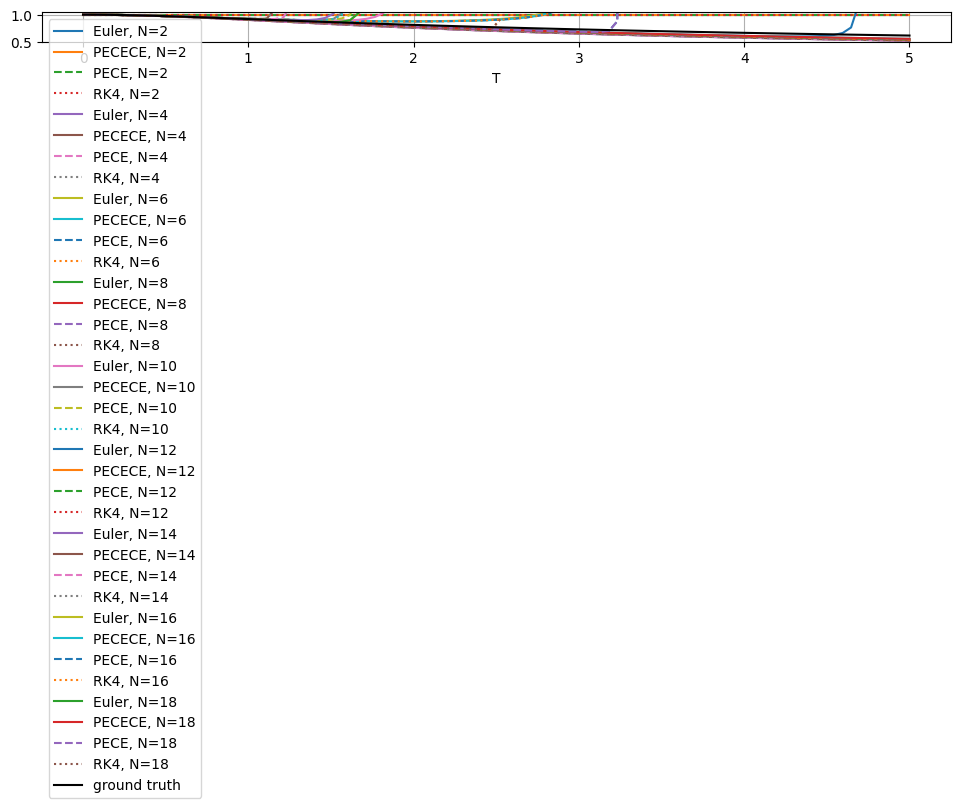

In [263]:
fig, ax = plt.subplots()

for trunc in [2, 4, 6, 8, 10, 12, 14, 16, 18]:
    T = 5
    n = 100
    u_coef = -1
    t_grid = np.linspace(0, T, n)
    
    u = ta.from_word("2222", trunc=trunc) * u_coef
    
    psi_euler, psi_0_euler = psi_riccati(t_grid=t_grid, u=u)
    psi_rk, psi_0_rk = psi_riccati_rk4(t_grid=t_grid, u=u)
    psi_pece, psi_0_pece = psi_riccati_pece(t_grid=t_grid, u=u)
    psi_pecece, psi_0_pecece = psi_riccati_pecece(t_grid=t_grid, u=u)
    
    ax.plot(t_grid, np.exp(psi_0_euler), "-", label=f"Euler, N={trunc}")
    ax.plot(t_grid, np.exp(psi_0_pecece), "-", label=f"PECECE, N={trunc}")
    ax.plot(t_grid, np.exp(psi_0_pece), "--", label=f"PECE, N={trunc}")
    ax.plot(t_grid, np.exp(psi_0_rk), ":", label=f"RK4, N={trunc}")
    
    
N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f(x):
    return np.exp(u_coef * t_grid[:, None]**2 * x[None, :]**4 / 24 - 0.5 * x[None, :]**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad[-1]
ax.plot(t_grid, cf_quad, "-k", label="ground truth")
ax.set_xlabel("T")
ax.set_ylim([0.5, 1.05])
ax.legend()

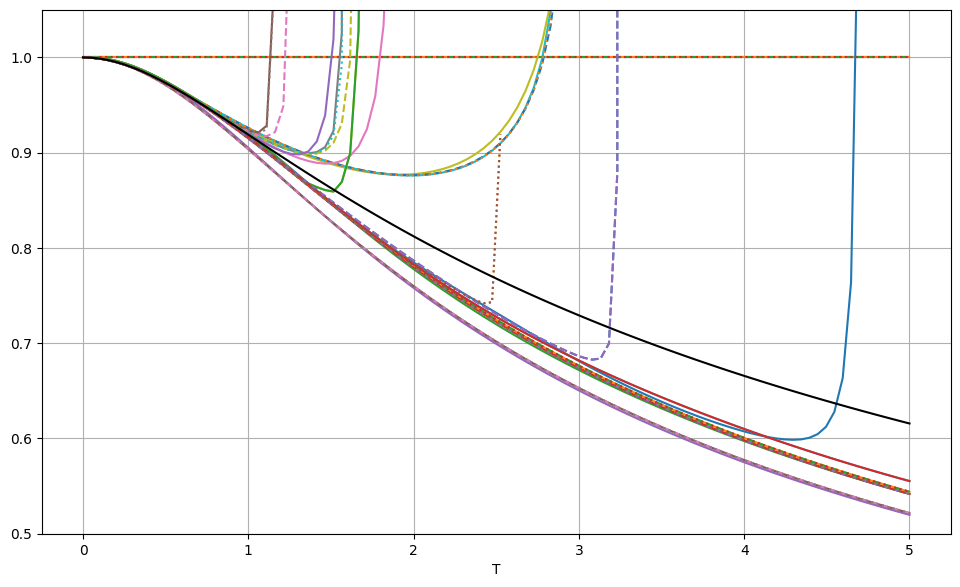

In [267]:
leg = ax.legend()
leg.remove()
fig

/tmp/ipykernel_22049/2340263050.py:13: RuntimeWarning: overflow encountered in exp
  ax.plot(t_grid, np.exp(psi_0_pecece), "--", label=f"PECECE, N={trunc}")


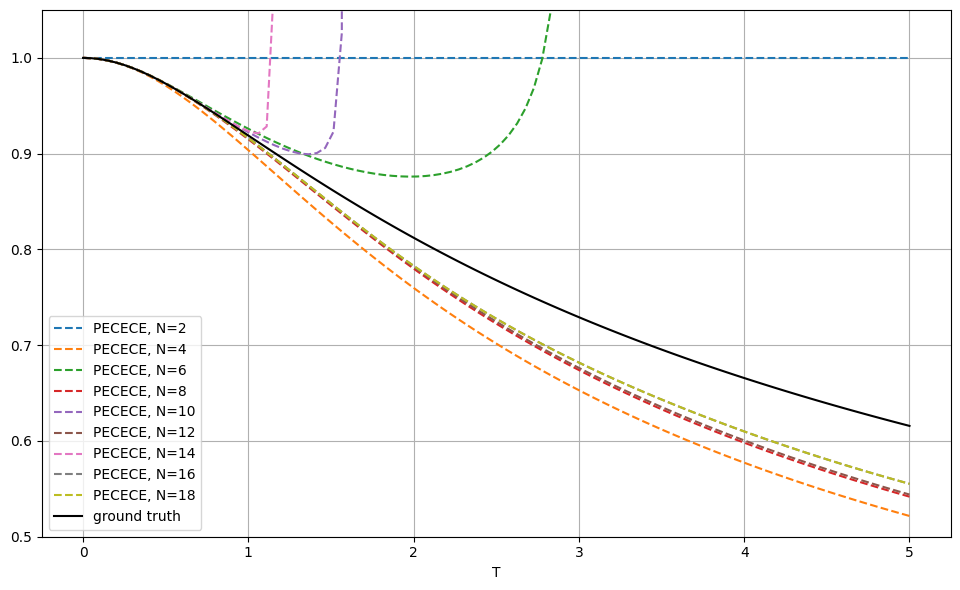

In [269]:
fig, ax = plt.subplots()

for trunc in [2, 4, 6, 8, 10, 12, 14, 16, 18]:
    T = 5
    n = 100
    u_coef = -1
    t_grid = np.linspace(0, T, n)
    
    u = ta.from_word("2222", trunc=trunc) * u_coef

    psi_pecece, psi_0_pecece = psi_riccati_pecece(t_grid=t_grid, u=u)
    
    ax.plot(t_grid, np.exp(psi_0_pecece), "--", label=f"PECECE, N={trunc}")
    
    
N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f(x):
    return np.exp(u_coef * t_grid[:, None]**2 * x[None, :]**4 / 24 - 0.5 * x[None, :]**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad[-1]
ax.plot(t_grid, cf_quad, "-k", label="ground truth")
ax.set_xlabel("T")
ax.set_ylim([0.5, 1.05])
ax.legend()

In [271]:
ta.print(_12.shuffle_prod(_12))

4.0*1122 + 2.0*1212


### Dependence on the discretization step

/tmp/ipykernel_22049/2519475380.py:15: RuntimeWarning: overflow encountered in exp
  ax.plot(t_grid, np.exp(psi_0_rk), "--", label=f"rk4, n_points={n}")


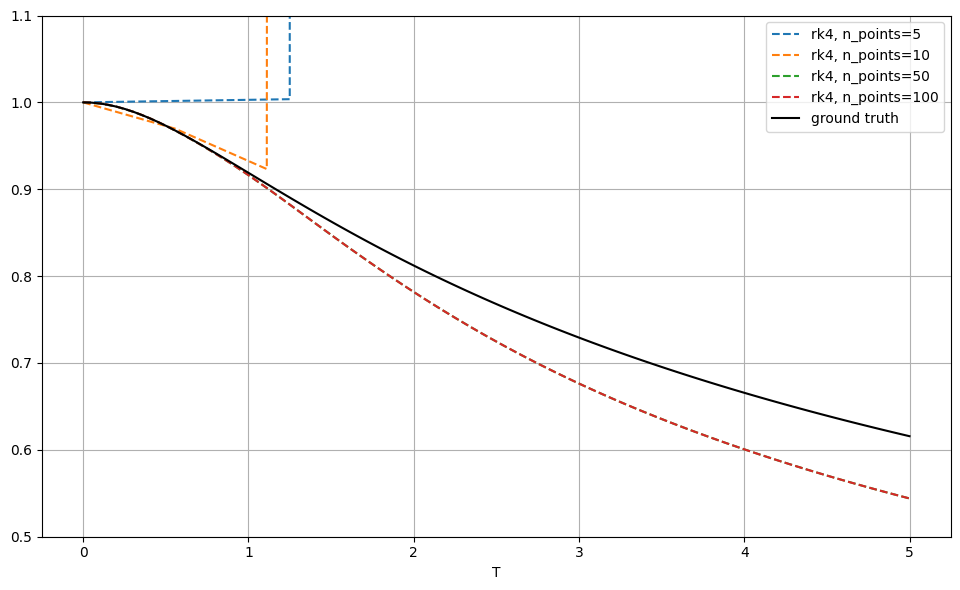

In [172]:
fig, ax = plt.subplots()

for n in [5, 10, 50, 100]:
    T = 5
    u_coef = -1
    trunc = 12
    t_grid = np.linspace(0, T, n)
    
    u = ta.from_word("2222", trunc=trunc) * u_coef
    
    # psi_euler, psi_0_euler = psi_riccati(t_grid=t_grid, u=u)
    psi_rk, psi_0_rk = psi_riccati_rk4(t_grid=t_grid, u=u)
    
    # ax.plot(t_grid, np.exp(psi_0_euler), "-", label=f"Euler, N={trunc}")
    ax.plot(t_grid, np.exp(psi_0_rk), "--", label=f"rk4, n_points={n}")

    
    
N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f(x):
    return np.exp(u_coef * t_grid[:, None]**2 * x[None, :]**4 / 24 - 0.5 * x[None, :]**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad[-1]
ax.plot(t_grid, cf_quad, "-k", label="ground truth")
ax.set_xlabel("T")

ax.set_ylim([0.5, 1.1])
ax.legend()

## Stationary signature characteristic function

In [5]:
T = 20
n = 1000
trunc = 12
u_coef = -1
lam = 0.1

t_grid = np.linspace(0, T, n)
u = ta.from_word("2222", trunc=trunc) * u_coef

#### Via MC

In [6]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
X_T = rng.normal(size=n_sample) * np.sqrt(1 / (2 * lam))
sample = np.exp(u_coef * X_T**4 / 24)
sample.mean(), sample.std() / np.sqrt(n_sample)

(0.6159742350374403, 0.00040049598075565324)

#### Via quadratures

In [7]:
from scipy.special import roots_laguerre


N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f_stat(x):
    return np.exp(u_coef * (1 / 2 / lam)**2 * x**4 / 24 - 0.5 * x**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f_stat(z_arr) @ (w_arr * np.exp(z_arr))
cf_quad

0.6157202973049363

In [8]:
from signatures.stationary_signature import G, semi_integrated_scheme, G_resolvent

In [9]:
from signatures.characteristic_function import psi_riccati_euler_stat, psi_riccati_pece_stat

In [10]:
psi_euler, psi_0_euler = psi_riccati_euler_stat(t_grid=t_grid, u=u, lam=lam)

In [11]:
ta.print(psi_euler)

-0.6009544397089506*∅ + -0.0033809323110550516*22 + -3.0019937403484846e-06*2222 + 8.031568439511624e-09*222222 + 8.764772016835374e-10*22222222 + -9.377074076706108e-12*2222222222 + -1.3724223726100796e-12*222222222222


In [13]:
psi = u * 1
for i in range(10):
    psi.update(
        G_resolvent(psi + func_psi(psi), lam)
    )
ta.print(psi)

492212984920.795*∅ + 8.075769559202518e+23*22 + -3.1274214497221146e+27*2222 + 1.2489381853440133e+31*222222 + -5.1276876530498695e+34*22222222 + 2.1500496950223836e+38*2222222222 + -9.13872339688034e+41*222222222222


In [323]:
psi_pece, psi_0_pece = psi_riccati_pece_stat(t_grid=t_grid, u=u, lam=lam)

In [324]:
ta.print(psi_pece)

-0.6003188870233214*∅ + -0.0033791231057222924*22 + -2.796747609291889e-06*2222 + -8.581463765653749e-09*222222 + 3.9786364555041023e-10*22222222 + 1.1460165984637001e-11*2222222222


../signatures/tensor_algebra.py:214: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(coefficients, "o", **kwargs)


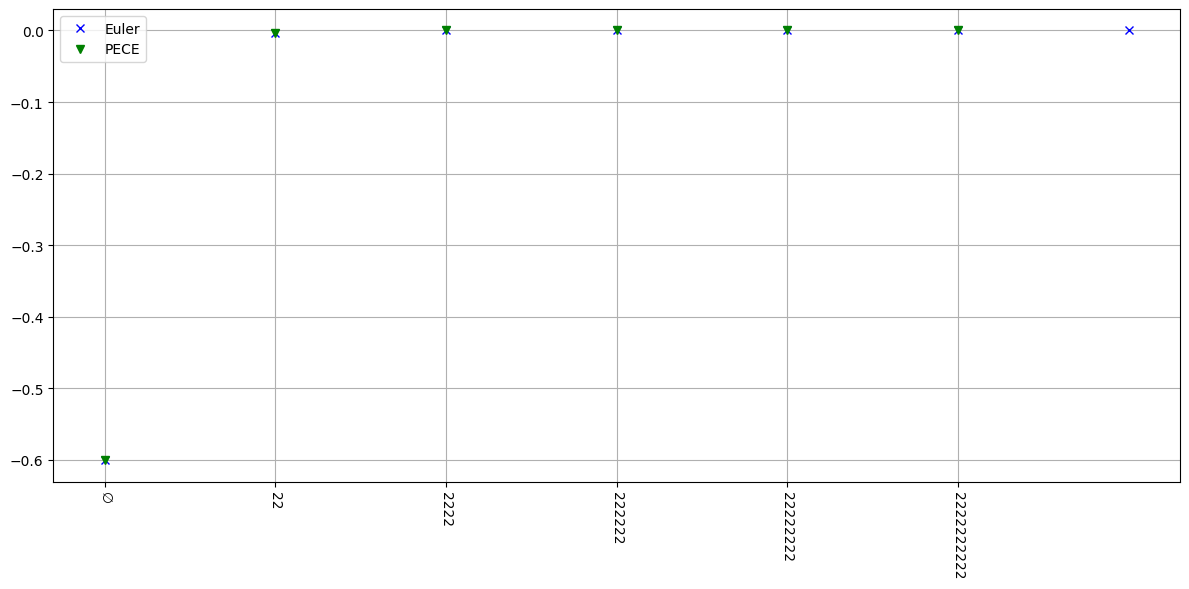

In [325]:
fig, ax = plt.subplots(figsize=(12, 6))

ta.plot_coefficients(ts=psi_euler, nonzero=True, ax=ax, color="b", marker="x", label="Euler")
ta.plot_coefficients(ts=psi_pece, nonzero=True, ax=ax, color="g", marker="v", label="PECE")

ax.legend()
# ax.set_ylim([-0.75, 0.05])

../signatures/tensor_algebra.py:214: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(coefficients, "o", **kwargs)


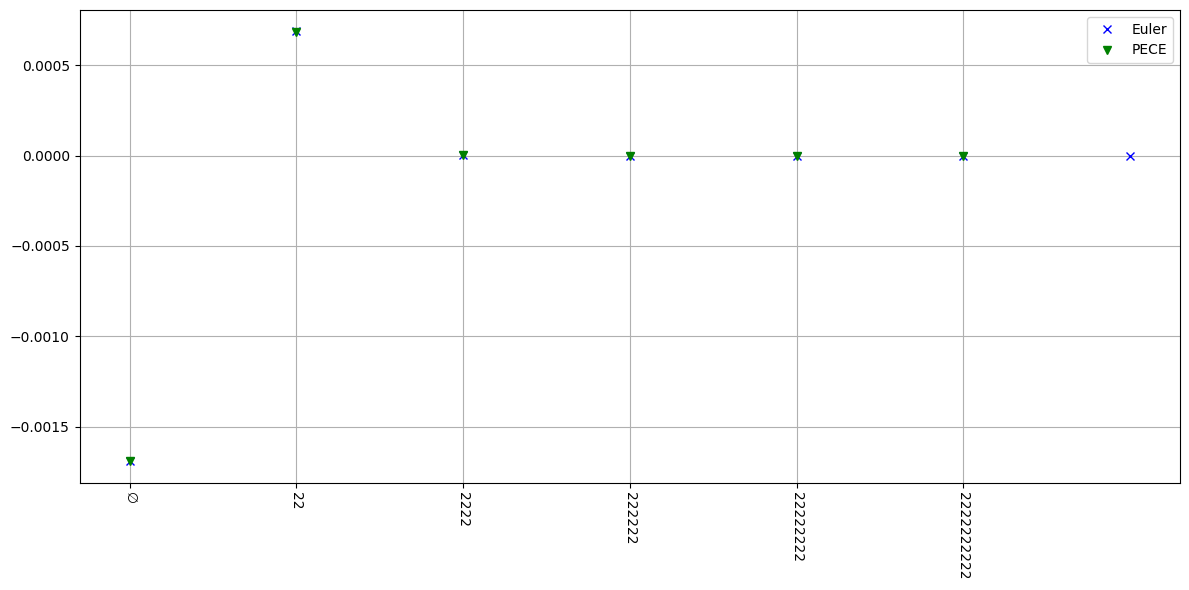

In [326]:
fig, ax = plt.subplots(figsize=(12, 6))

ta.plot_coefficients(ts=func_psi_stat(psi_euler, lam=lam), nonzero=True, ax=ax, color="b", marker="x", label="Euler")
ta.plot_coefficients(ts=func_psi_stat(psi_pece, lam=lam), nonzero=True, ax=ax, color="g", marker="v", label="PECE")

# ax.set_ylim([-0.1, 0.05])
ax.legend()

### Dependence on the truncation order

In [256]:
1 / np.sqrt(1 / 2 / lam + 1)

0.8944271909999159

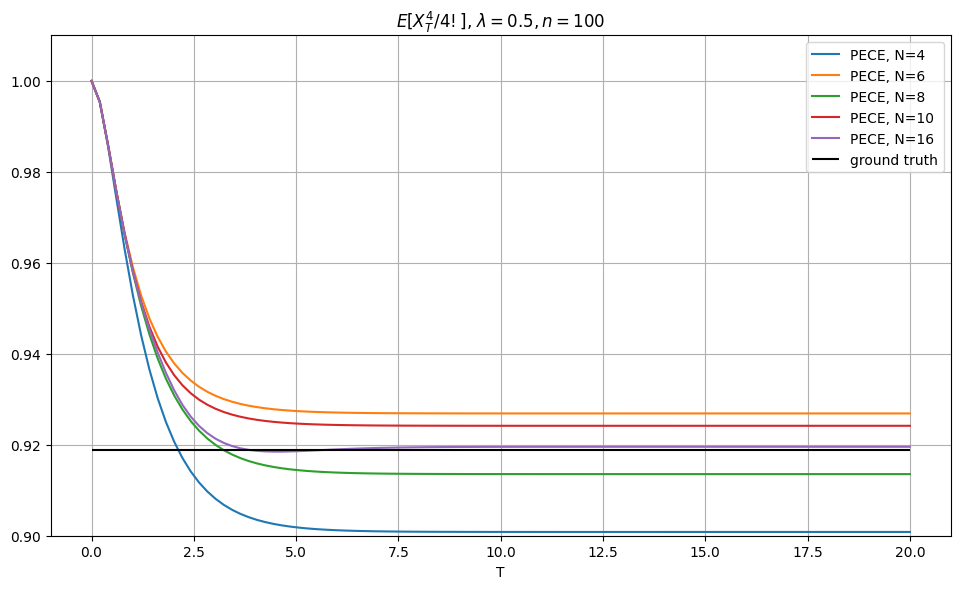

In [299]:
fig, ax = plt.subplots()

for trunc in [4, 6, 8, 10, 16]:
    T = 20
    n = 100
    u_coef = -1
    t_grid = np.linspace(0, T, n)
    lam = 0.5
    
    u = ta.from_word("2222", trunc=trunc) * u_coef
    
    psi_euler, psi_0_euler = psi_riccati_euler_stat(t_grid=t_grid, u=u, lam=lam)
    psi_pece, psi_0_pece = psi_riccati_pece_stat(t_grid=t_grid, u=u, lam=lam)
    
    # ax.plot(t_grid, np.exp(psi_0_euler), "-", label=f"Euler, N={trunc}")
    ax.plot(t_grid, np.exp(psi_0_pece), "-", label=f"PECE, N={trunc}")
        
N_points = 160

z_arr, w_arr = roots_laguerre(n=N_points)

def f_stat(x):
    return np.exp(u_coef * (1 / 2 / lam)**2 * x**4 / 24 - 0.5 * x**2) / np.sqrt(2 * np.pi) * 2

cf_quad = f_stat(z_arr) @ (w_arr * np.exp(z_arr))

ax.hlines(cf_quad, t_grid[0], t_grid[-1], color="k", label="ground truth")
ax.set_xlabel("T")
ax.set_ylim([0.9, 1.01])
ax.set_title("$E[{X_T^4}/{4!}]$" + f", $\lambda = {lam}, n = {n}$")
ax.legend()

In [334]:
eps = 1e-6
eps

1e-06

In [335]:
1 / lam * np.log(lam * eps)

-161.1809565095832

In [327]:
lam

0.1